I. Introduction
II. Methodology
   A. Univariate Audit
   B. Model Building
      a. Training Data
      b. Testing Data
III. Results and Insights
IV. Takeaways

## I. Introduction

This data science assessment aims to leverage exploratory, univariate audits findings to build a machine-learning model, with a focus on finding insights indicative of the people who make more than $50,000/year.

In [29]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import zipfile
from pandas import read_excel
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

#z = zipfile.ZipFile('us_census_full.zip')
#z.extractall()
#z.close()

In [3]:
# change direction to unzipped data
import os

def change_path():
    os.chdir(os.getcwd() + '/us_census_full/')

change_path()

In [30]:
#  open metadata text file to obtain column names
with open('census_income_metadata.txt', 'r') as file:
    col_names_data = file.read().split('\n')

# empty list for column names    
col_names = []

# obtain column names and store in lkist
for i in col_names_data[23:68]:
    col = i[2:].split('\t')[0].replace(' ', '_')
    if col not in ['adjusted_gross_income', 'federal_income_tax_liability', 'total_person_earnings',
                  'total_person_income', 'taxable_income_amount']:
        col_names.append(col)
    elif col == 'mace':
        col_names.append('race')
# append columns that were missed out        
col_names.append('year')
col_names.append('50k_threshold')

In [41]:
# read in training and testing data, using column names from metadata text file
census_income_learn_df = pd.read_csv("census_income_learn.csv", header = None, 
                                     names = col_names, sep = ',', usecols=col_names, na_values=["?"])
census_income_test_df = pd.read_csv("census_income_test.csv", header = None, 
                                    names = col_names, sep = ',', usecols=col_names, na_values=["?"])

In [33]:
%pprint # pretty print is awesome :D

Pretty printing has been turned ON


In [47]:
# Convert some columns into string dtypes
for col in census_income_learn_df.columns:
    if col in ['industry_code', 'occupation_code', 'own_business_or_self_employed', 'veterans_benefits', 'year']:
        census_income_learn_df[col] = census_income_learn_df[col].astype(str)
# replace all '?' with NANs
census_income_learn_df = census_income_learn_df.replace('?', np.NaN)

# Convert some columns into string dtypes
for col in census_income_test_df.columns:
    if col in ['industry_code', 'occupation_code', 'own_business_or_self_employed', 'veterans_benefits', 'year']:
        census_income_test_df[col] = census_income_test_df[col].astype(str)
# replace all '?' with NANs
census_income_test_df = census_income_test_df.replace('?', np.NaN)

In [34]:
import pickle
# pickle files for later use
with open('census_income_learn_df.pickle', 'wb') as handle:
    pickle.dump(census_income_learn_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('census_income_test_df.pickle', 'wb') as handle:
    pickle.dump(census_income_test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
import pickle
# load pickle files
with open('census_income_learn_df.pickle', 'rb') as handle:
    census_income_learn_df = pickle.load(handle)

with open('census_income_test_df.pickle', 'rb') as handle:
    census_income_test_df = pickle.load(handle)

###  Univariate Audit
####  Missing Data Descriptive Analysis

In [53]:
percent_missing = census_income_learn_df.isna().sum()/ len(census_income_learn_df)
percent_missing # calculate % of missing data per column

age                                           0.0
class_of_worker                               0.0
industry_code                                 0.0
occupation_code                               0.0
education                                     0.0
wage_per_hour                                 0.0
enrolled_in_edu_inst_last_wk                  0.0
marital_status                                0.0
major_industry_code                           0.0
major_occupation_code                         0.0
mace                                          0.0
hispanic_Origin                               0.0
sex                                           0.0
member_of_a_labor_union                       0.0
reason_for_unemployment                       0.0
full_or_part_time_employment_stat             0.0
capital_gains                                 0.0
capital_losses                                0.0
divdends_from_stocks                          0.0
tax_filer_status                              0.0


Results indicate that there aren't any missing data.

## Visualization and Statistical Analysis of Each Variable 

In [6]:
# create placeholder dataframe
filt_df = census_income_learn_df

# parse out int and object columns
# empty lists
int_list = []
obj_list = []

# loop through columns
for i, col in enumerate(filt_df.columns):
    if (filt_df[col].dtype == np.int64 or filt_df[col].dtype == np.float64):
        int_list.append(col) # if column.dtype is int or float, store in int list
    elif str(filt_df[col].dtype) == 'object':
        if col not in ['occupation_code', 'industry_code']:
            obj_list.append(col) # if column.dtype is object, store in obj list
    if col == '50k_threshold':
        int_list.append(col) # store '50k_threshold' into int list

# Function to show boxplots and t-test results for each integer/float column        
def plot_int_vars():
    # define figure size
    plt.rc('figure', figsize=[24, 12])
    # define figure and axes parameters of the subplots
    fig, axes = plt.subplots(4, 2, constrained_layout=True, sharex=False, sharey=False, figsize = (12, 12))
    plt.subplots_adjust(wspace=0.1, hspace=0.2) # define spacing between the plots
    
    # created placeholder int list, just in case
    df_col_list = filt_df[int_list].columns    
    
    # traverse across nrow, ncol of the subplot grid and populate each section with a boxplot and t-test result
    for nrow in range(0, 4):
        for ncol in range(0, 2):
            i = nrow + ncol # create value for index for the column list
            col = df_col_list[i] # obtain column name from column list
            if col != '50k_threshold': # if the column isn't '50k_threshold'
                #filt_df[col] = filt_df[col].dropna()
                twenty_tile = np.percentile(filt_df[col], 20) # calculate the 20th percentile
                eighty_tile = np.percentile(filt_df[col], 80) # calculate the 80th percentile
                filt_df.boxplot(col, by = '50k_threshold', ax = axes[nrow, ncol]) # boxplot of col by 50k threshold
                #plt.ylim([twenty_tile, eighty_tile])
                axes[nrow, ncol].set_autoscaley_on(True) # autoscale
                axes[nrow, ncol].set(xlabel = "59k_threshold", ylabel = col, #labels for the x-, y-, title
                                 title = '50k_threshold Across {}'.format(col))
                
                ## statistical test
                # return column of current iteration's value split by special group and avg group
                under_50k = filt_df[filt_df['50k_threshold'] == ' - 50000.'][col]
                over_50k = filt_df[filt_df['50k_threshold'] == ' 50000+.'][col]
                # perform independent sample t-test to see distribution significance
                results = stats.ttest_ind(over_50k, under_50k, axis = 0, equal_var = False)
                # insert result into each subplot
                axes[nrow, ncol].text(0.89,-0.15, 'p = {0:.3g}'.format(results[1]), size=10, 
                                      ha="center", transform=axes[nrow, ncol].transAxes)
                
    fig.suptitle('')
    plt.tight_layout()
    # voila!
    plt.show()

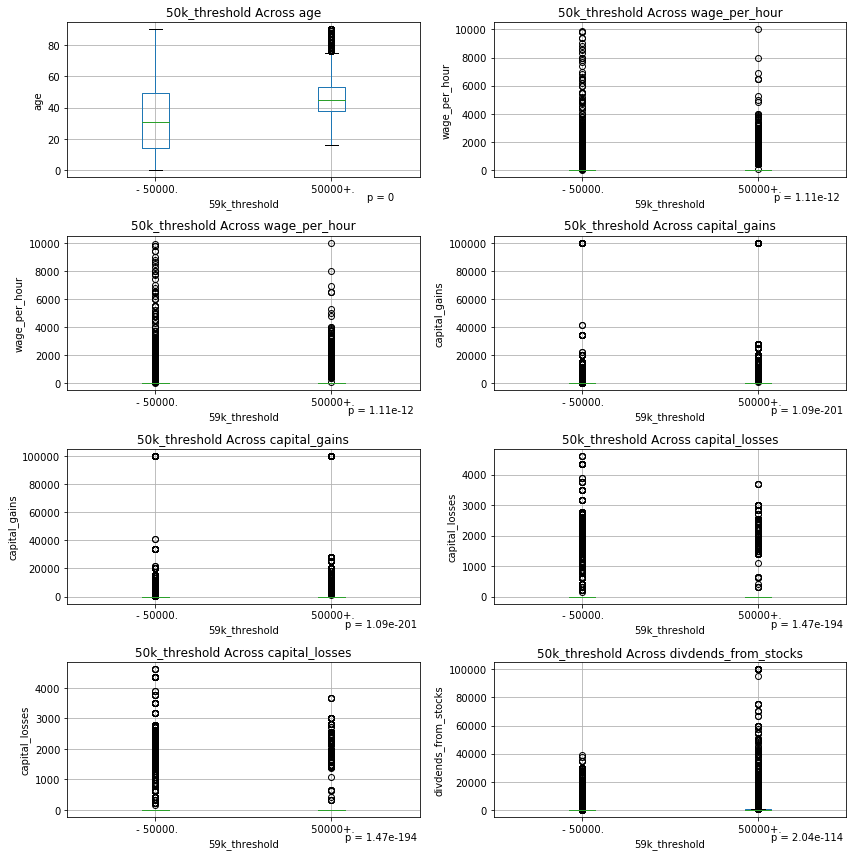

In [34]:
plot_int_vars()

In [64]:
# Function to show stacked barcharts and chi-square t-test results for each object column
def plot_obj_vars(left, right): # left, right denotes index placeholders, since it's unfeasible to show all 33 plots at once!
    # define figure parameters
    plt.rc('figure', figsize=[136, 16])
    # define subplot parameters
    fig, axes = plt.subplots(2, 2, constrained_layout=True, sharex=False, sharey=False, figsize = (16, 16))
    plt.subplots_adjust(wspace=0.2, hspace=0.2) # define spacing between barcharts
    
    # loop through columns within defined indices
    for i, col in enumerate(filt_df[obj_list].columns[left:right]):
        filt_df[col] = filt_df[col].dropna() # drop missing values
        stkd_bchar = filt_df.groupby([col, '50k_threshold']).size().unstack() # groupby/unstack data
        stkd_bchar.plot(kind = 'bar', stacked = True, ax = axes.flatten()[i]) # plot stacked barchart in appropriate axis
        plt.xlabel(col) # define x label
        plt.ylabel('Unit of Measure') # define y label
        axes.flatten()[i].set_title('50k_threshold Across {}'.format(col)) # set title
        plt.xticks(rotation=45, ha='right') # rotate x-axis labels
        
        ## statistical test
        # return column of current iteration's value split by special group and avg group
        under_50k = filt_df['age']
        over_50k = filt_df['50k_threshold']
        # perform independent sample t-test to see distribution significance
        results = stats.chi2_contingency(pd.crosstab(under_50k, over_50k))
        # insert result into each subplot
        axes.flatten()[i].text(0.0, 0.0, 'p = {0:.3g}'.format(results[1]), size=10, 
                              ha="right")
        
    plt.suptitle('')
    plt.tight_layout()
    # voila!
    plt.show()


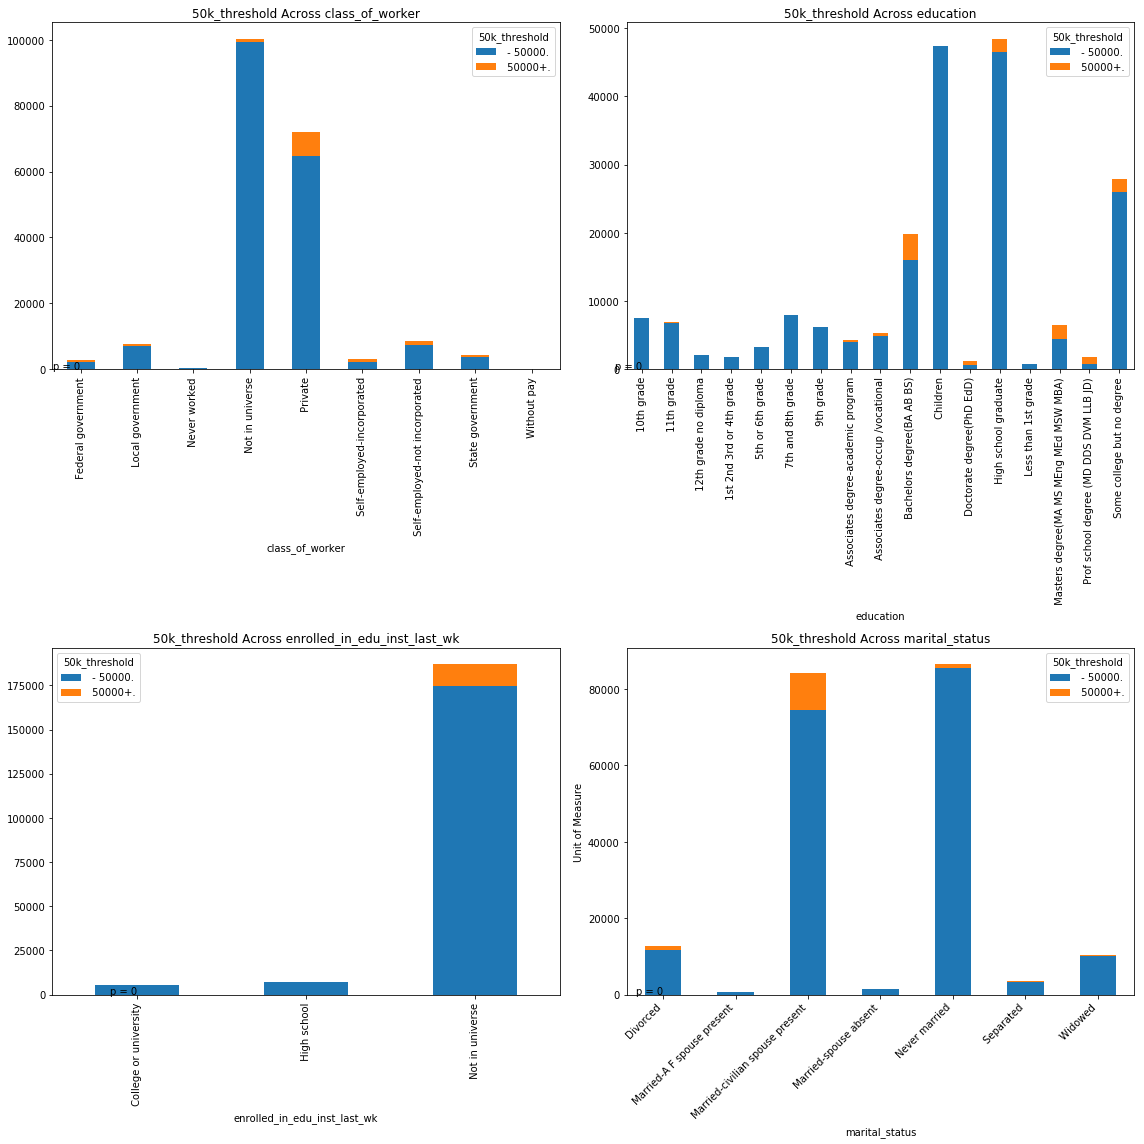

In [65]:
plot_obj_vars(0, 4)

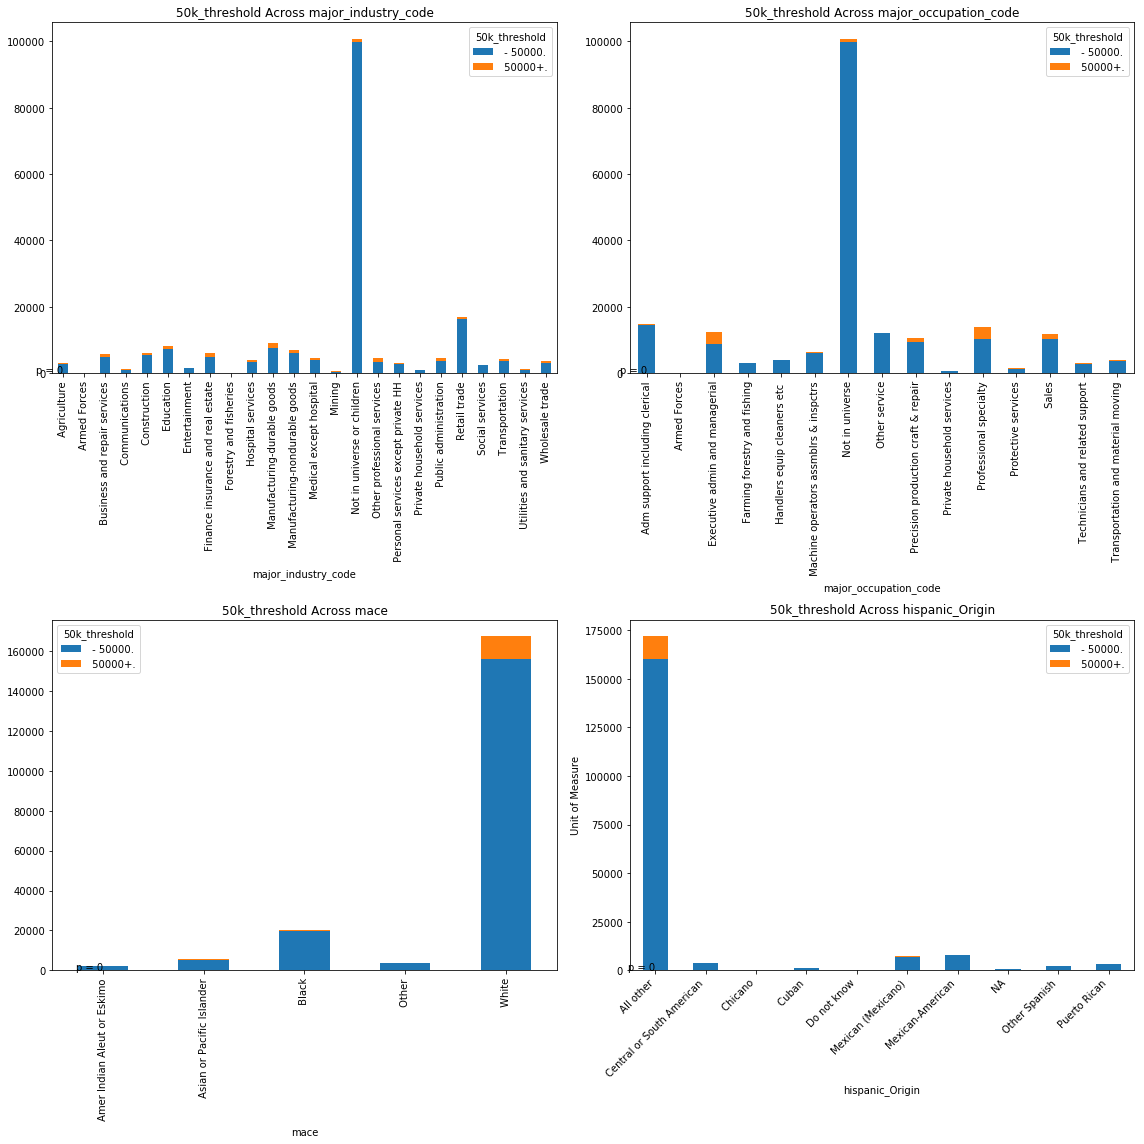

In [66]:
plot_obj_vars(4, 8)

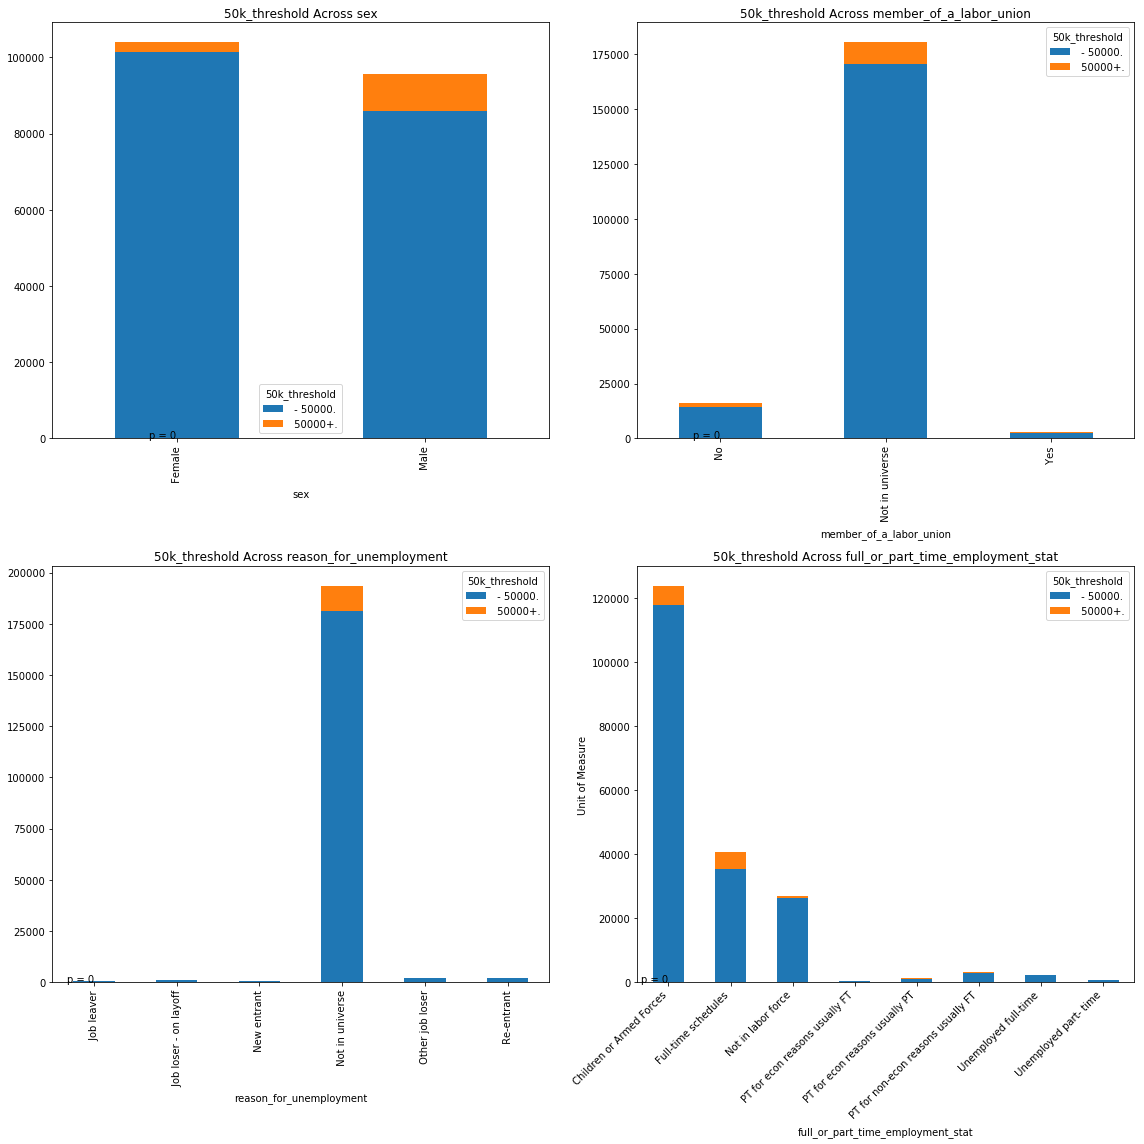

In [67]:
plot_obj_vars(8, 12)

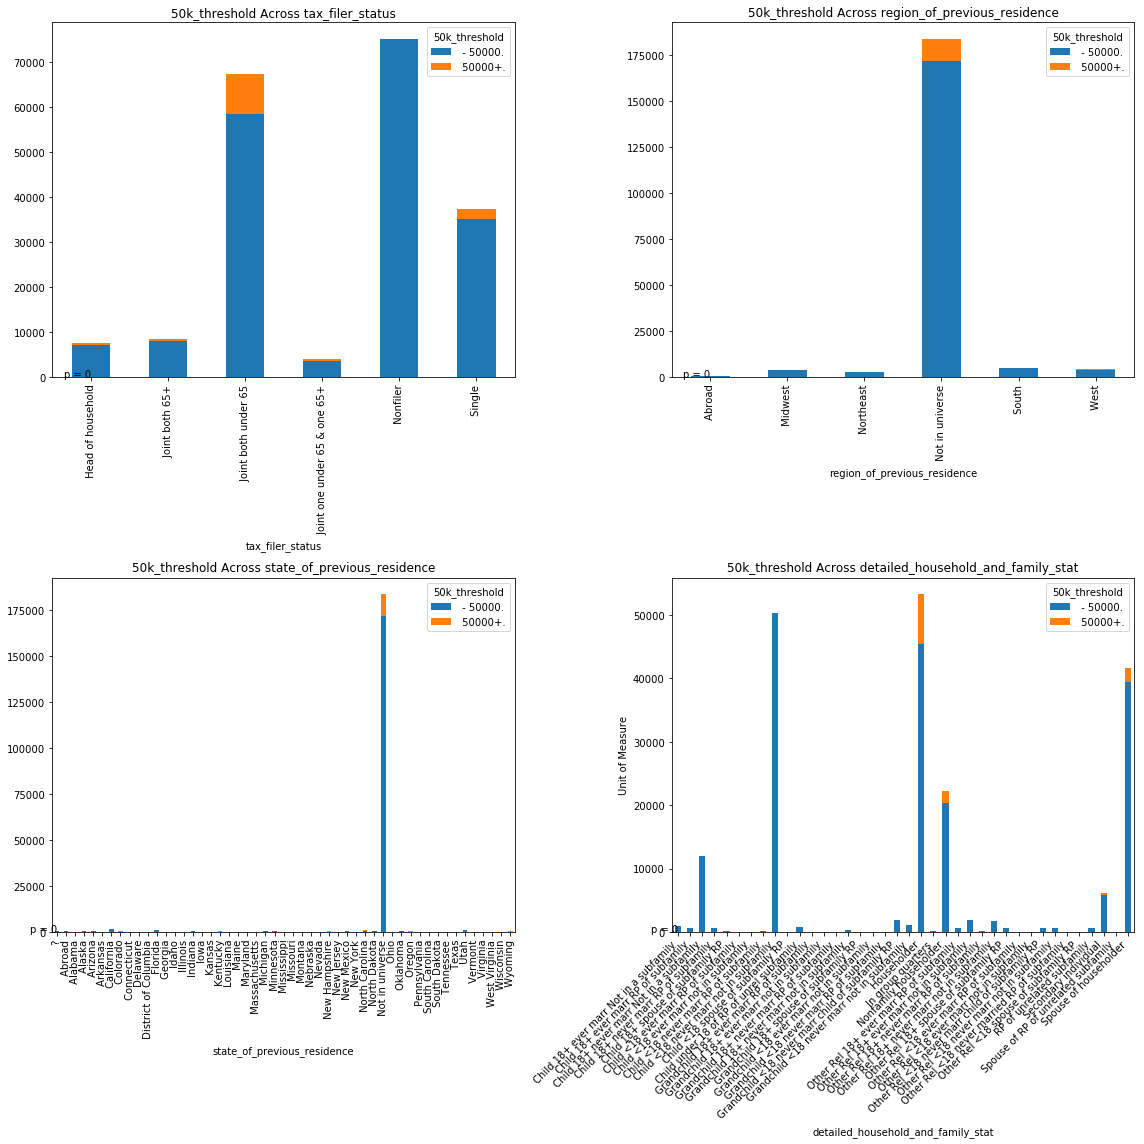

In [68]:
plot_obj_vars(12, 16)

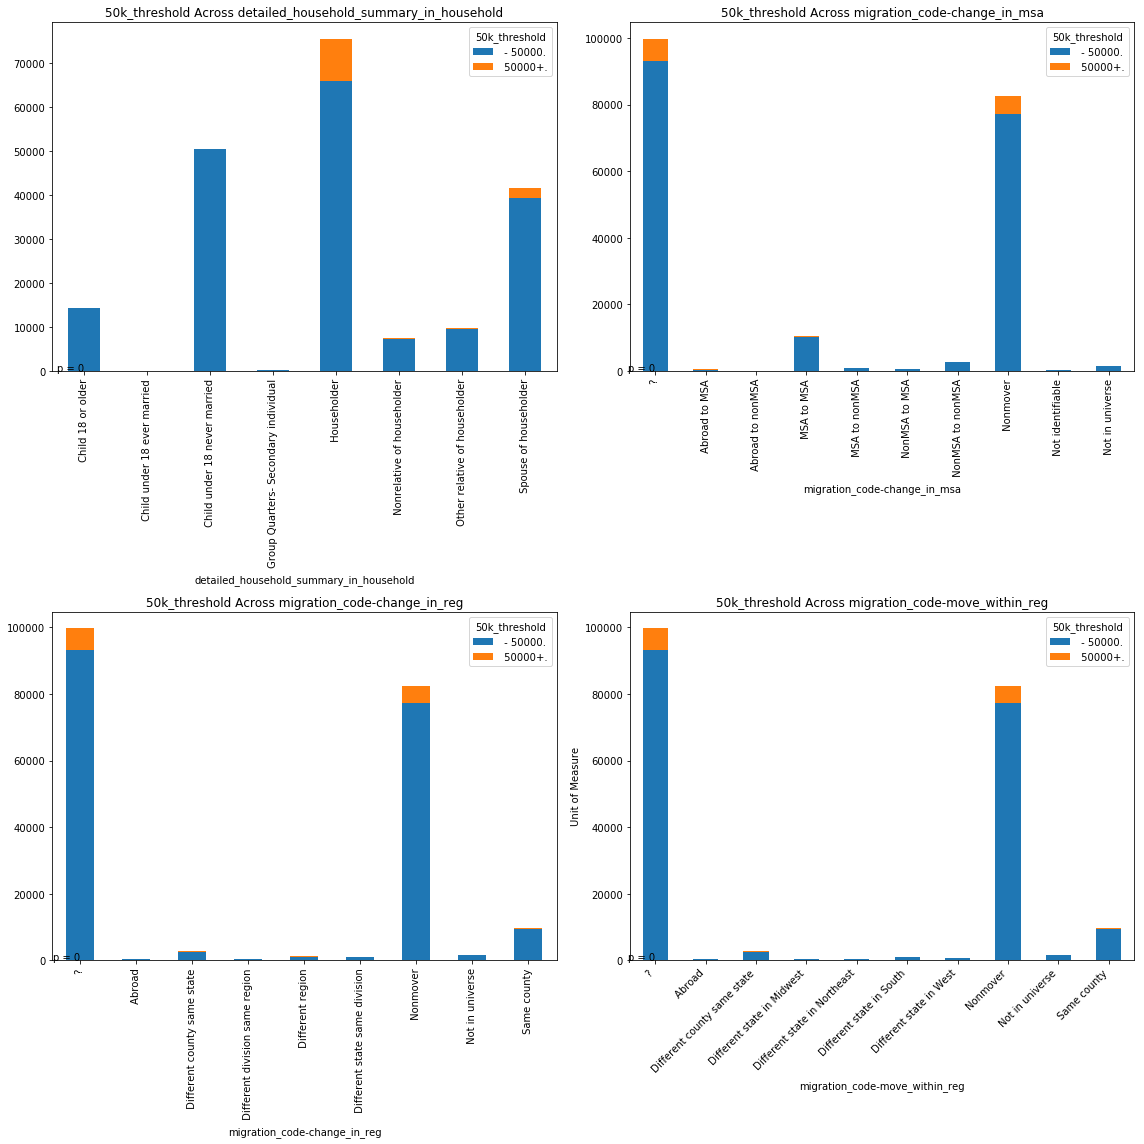

In [69]:
plot_obj_vars(16, 20)

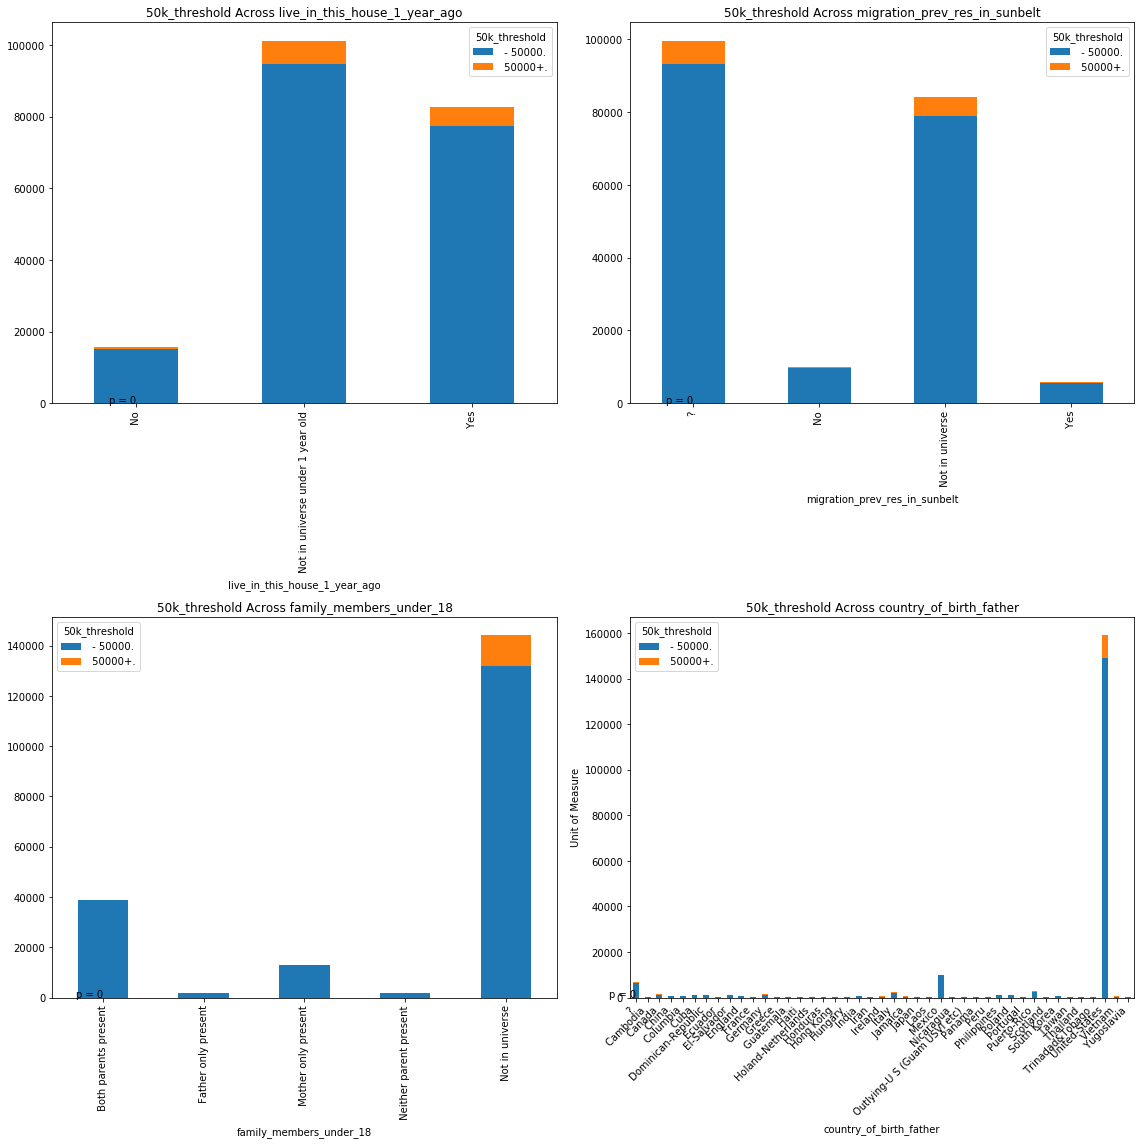

In [70]:
plot_obj_vars(20, 24)

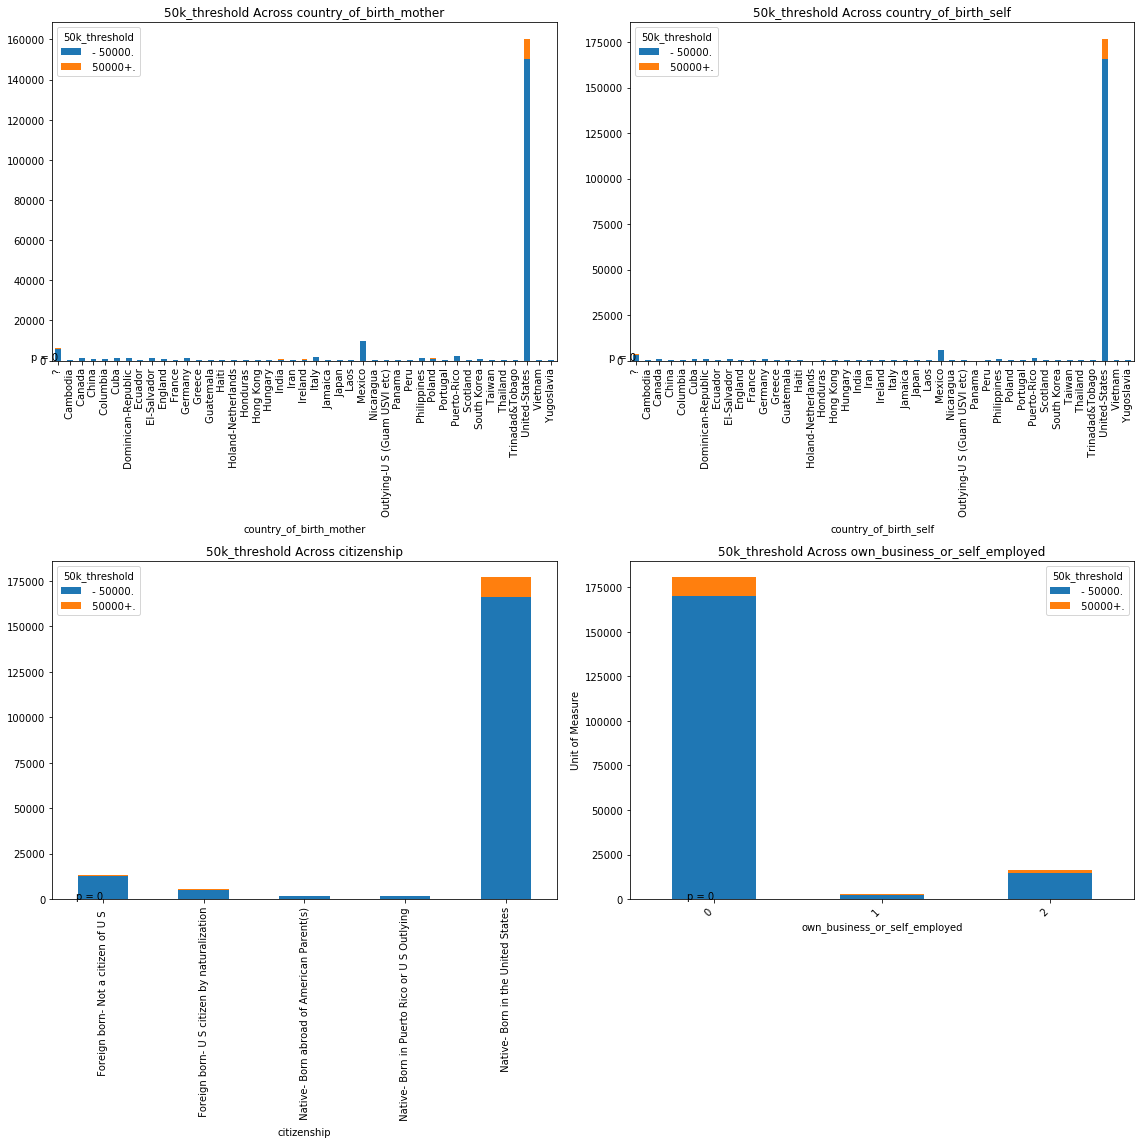

In [71]:
plot_obj_vars(24, 28)

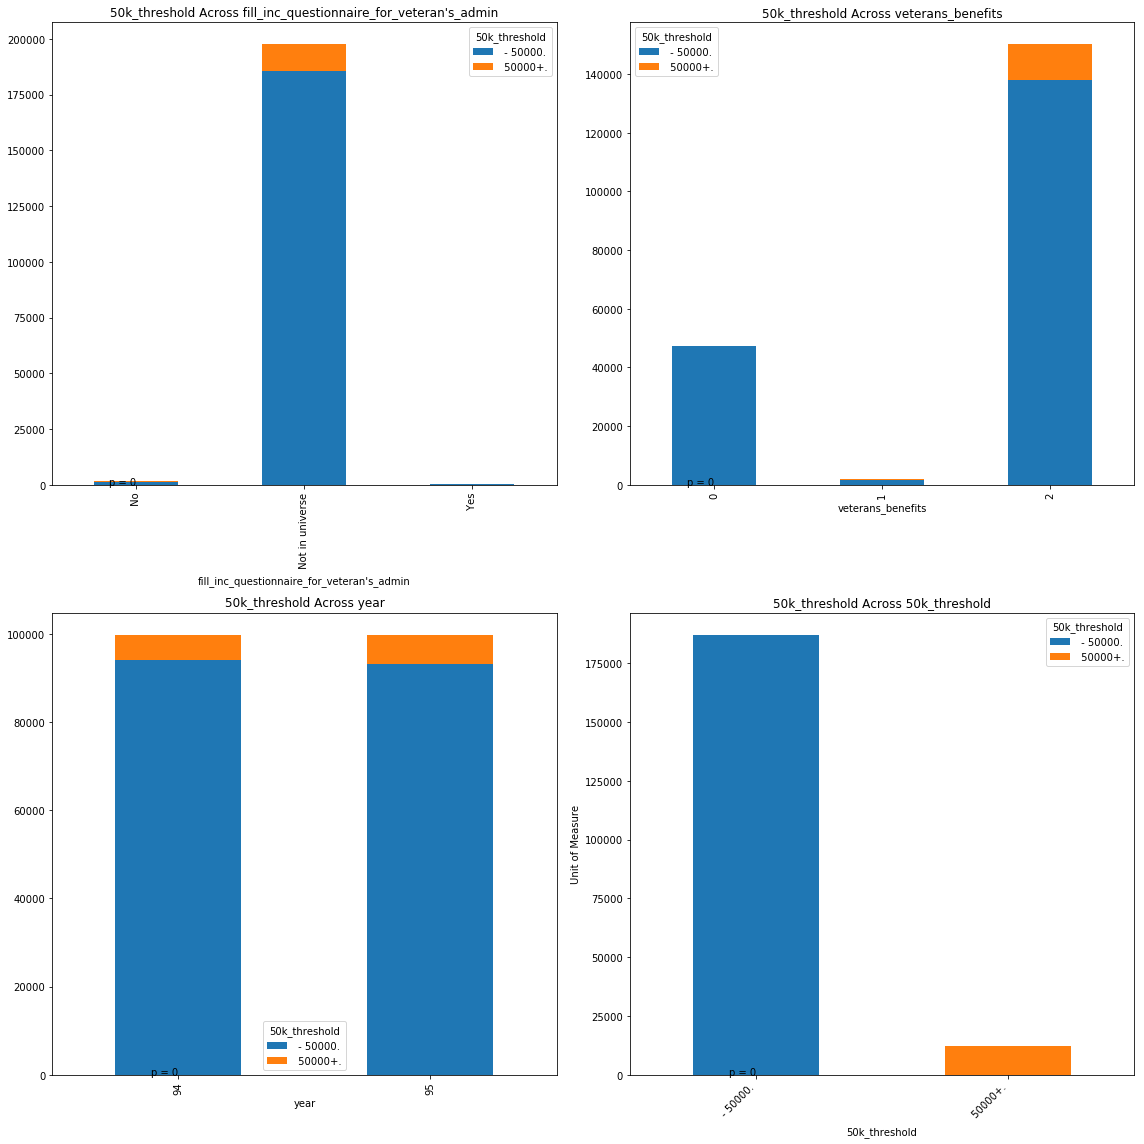

In [72]:
plot_obj_vars(28, 32)

In [138]:
import pickle

with open('census_income_learn_df.pickle', 'wb') as handle:
    pickle.dump(census_income_learn_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('census_income_test_df.pickle', 'wb') as handle:
    pickle.dump(census_income_test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [139]:
import pickle

with open('census_income_learn_df.pickle', 'rb') as handle:
    census_income_learn_df = pickle.load(handle)

with open('census_income_test_df.pickle', 'rb') as handle:
    census_income_test_df = pickle.load(handle)

## Metholodology: Training and Test Data

I utilized a multiple of models for exploratory analysis before stick with two.
   - Model 1: ExtraTreesClassifier
   - Model 2: SGFClassifier
   - Other Models used:
     - Exploratory Analysis: GaussianNB
     - Feature Selection: Linear Support Vector Classifier
     - Other: RandomForest Classifier

My machine-learning pipeline consists of the following:
   - Pipeline with Column/Function Transformers
   - Feature Union to pass results from Transformers to the Classifiers
   - Feature Selection using LinearSVC
   - Various Model Selection cross-validation techniques
   - Measures of Fit for Classification: ROC_Curve, Classification_Report (Precision/Recall/F-Score)
   - Unbalanced Classes: I initially incorporated a balanced class component, but opted for the 'class_weight' parameter in the                          ExtraTreesClassifier model

In [74]:
%%time

import scipy as sp
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, KFold, StratifiedKFold, train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve

# Load LabelEncoder to process string variables
le = preprocessing.LabelEncoder()

# Train, Test Data
def split_data(df_one, df_two, X, y):
    df = df_one.dropna(subset=[y])
    X_train = df_one[X]
    y_train = np.ravel(df_one[[y]].astype(str).apply(le.fit_transform))
    df = df_two.dropna(subset=[y])
    X_test = df_two[X]
    y_test = np.ravel(df_two[[y]].astype(str).apply(le.fit_transform))
    return X_train, X_test, y_train, y_test

# KFold for GridSearch
scv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to pass Description_lema for NLP processing
get_text_data = FunctionTransformer(lambda x: x['Description_lema'], validate=False)

# Function to pass object variables to string format before running labelencoder
get_numeric_feat_data = FunctionTransformer( # 
    lambda x: x[['year', 'member_of_a_labor_union', 'region_of_previous_residence', 'major_occupation_code', 
                 'occupation_code', 'detailed_household_summary_in_household',
                 'reason_for_unemployment', 'education', 'sex', 'tax_filer_status', 'country_of_birth_self', 
                 'industry_code', 'migration_code-change_in_reg', 'full_or_part_time_employment_stat', 
                 'enrolled_in_edu_inst_last_wk', 'state_of_previous_residence', 'hispanic_Origin', 'mace', 
                 'country_of_birth_father', 'detailed_household_and_family_stat', 'class_of_worker', 
                 'live_in_this_house_1_year_ago', 'citizenship', 'marital_status', 'migration_code-change_in_msa', 
                 'migration_code-move_within_reg', 'country_of_birth_mother', 'family_members_under_18', 
                 'major_industry_code', 'migration_prev_res_in_sunbelt', 'veterans_benefits', 
                 'own_business_or_self_employed']].astype(str).apply(le.fit_transform), validate=False)
# Function to pass numeric variables and use forwardfeed for missing data
get_numeric_data = FunctionTransformer(
    lambda x: x[['age', 'wage_per_hour', 'capital_gains', 'capital_losses', 'divdends_from_stocks', 'instance_weight',
                 'num_persons_worked_for_employer', 'weeks_worked_in_year']].fillna(method='ffill'), validate=False)

# N-Gram Pipeline
classification_pipeline = Pipeline([
    ('union', FeatureUnion([ # Feature Union to process different variables
            ('numeric_transformed_features', Pipeline([
                ('selector', get_numeric_feat_data)
            ])),
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data)
            ]))#,
            # ('text_features', Pipeline([
            #    ('selector', get_text_data),
            #    ('CountVectorizer', CountVectorizer(max_features=65536, 
            #                                        binary=True, 
            #                                        ngram_range=(1,2))),
            #     ('TfidfTransformer', TfidfTransformer())
            #]))
         ])), # First used SDGRegressor for processing speed during the exploratory phase before using RandomForest
    #('SGDRegressor', linear_model.SGDRegressor(max_iter = 10000, tol = 1e-3, random_state = 42))
    #('Naive_Bayes', GaussianNB(priors=None, var_smoothing=1e-09))
    #('feature_selection', SelectFromModel(LinearSVC(max_iter = 4000,
    #                                                penalty = "l1", 
    #                                                dual = False,
    #                                               random_state = 42))),
    ('ETRF_Classifier', ExtraTreesClassifier(max_depth = 40,
                                             n_estimators = 2000,
                                             max_features = 'sqrt',
                                             criterion = 'gini',
                                             class_weight = 'balanced',
                                             random_state = 42))
    #('SGDClassifier', linear_model.SGDClassifier(max_iter=10000, tol=1e-3, random_state = 42))
    #('RF_Regressor', RandomForestRegressor(max_depth = 30, 
    #                                       max_features = 'sqrt', 
    #                                       criterion= 'mse', 
    #                                       random_state=42, 
    #                                       n_estimators=500))
])                                            

# Parameters for GridSearch
parameters = {
    'union__transformer_weights': [{'CountVectorizer__max_df': [0.75, 1.0]},
                                   {'CountVectorizer__max_features': [50000, 65536]},
                                   #{'CountVectorizer__ngram_range': [(1, 6),
                                   #                                 (1, 4),
                                   #                                 (1, 2),
                                   #                                 (2, 4),
                                   #                                 (2, 6),
                                   #                                 (4, 6)]},
                                   {'TfidfTransformer__use_idf': [True]},
                                   {'TfidfTransformer__norm': ['l1', 'l2']},
                                   {'TfidfTransformer__sublinear_tf': ['1 + log(tf)']}
                                  ],
    #'CountVectorizer__max_df': [0.75, 1.0],
    #'CountVectorizer__max_features': [50000, 65536],
    #'CountVectorizer__ngram_range': [(1, 2)],  # unigrams or bigrams
    #'CountVectorizer__binary': [True],
    #'TfidfTransformer__use_idf': [True],
    #'TfidfTransformer__norm': ['l1', 'l2'],
    #'TfidfTransformer__sublinear_tf': ['1 + log(tf)'],
    #'feature_selection__max_iter': [3500, 4500, 5500],
    #'ETRF_Classifier__max_depth': [60, 80, 100],
    #'ETRF_Classifier__n_estimators': [500, 600, 700, 800]
    #'Regressor__alpha': [0.001, 0.0001, 0.00001, 0.000001],
    #'Regressor__penalty': ['l2', 'elasticnet'],
}

# Pipeline
grid_search = GridSearchCV(classification_pipeline, parameters, n_jobs=1, verbose=1, cv = scv)

CPU times: user 324 ms, sys: 57 ms, total: 381 ms
Wall time: 392 ms


Here are some initial exploratory results of the models before deciding on a model and hyperparameters, based on roc_curve AUC, precision/recall/f1-score/weighted avg/processing speed.

In [75]:
%%time
# Here are some more results using LinearSVC for feature selection

# initial:                                                   .981, .95/1.0/.98, .84/.29/.43, .95/.95/.94
# with SVC for feat selection:                               .980, .95/1.0/.98, .84/.29/.43, .95/.95/.94
# SVC, max_iter: 2000; RF: max_depth: 30, n_estimators: 200: .991, .96/.99/.98, .80/.33/.47, .95/.95/.94
# RF: max_depth: 40, n_estimators: 300:                      .999, .96/.99/.98, .76/.36/.49, .95/.95/.95, .9988
# RF: max_depth: 50, n_estimators: 400:                      .999, .96/.99/.97, .73/.37/.49, .95/.95/.95, .9995
# class_weight: balanced_subsample:                          .999, .96/.99/.97, .73/.33/.45, .94/.95/.94, .9999949
# max_depth: 60, n_estimators: 1000:                         .999, .96/.99/.97, .76/.32/.45, .94/.95/.94, .9999949880464909

# Splits data
give_data = split_data(census_income_learn_df, census_income_test_df,
                       X = ['age', 'class_of_worker', 'industry_code', 'occupation_code',
       'education', 'wage_per_hour', 'enrolled_in_edu_inst_last_wk',
       'marital_status', 'major_industry_code', 'major_occupation_code',
       'mace', 'hispanic_Origin', 'sex', 'member_of_a_labor_union',
       'reason_for_unemployment', 'full_or_part_time_employment_stat',
       'capital_gains', 'capital_losses', 'divdends_from_stocks',
       'tax_filer_status', 'region_of_previous_residence',
       'state_of_previous_residence', 'detailed_household_and_family_stat',
       'detailed_household_summary_in_household', 'instance_weight',
       'migration_code-change_in_msa', 'migration_code-change_in_reg',
       'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer',
       'family_members_under_18', 'country_of_birth_father',
       'country_of_birth_mother', 'country_of_birth_self', 'citizenship',
       'own_business_or_self_employed', 'veterans_benefits',
       'weeks_worked_in_year', 'year'], y = "50k_threshold")

# Train and Test data
X_train, X_test, y_train, y_test = give_data[0], give_data[1], give_data[2], give_data[3]

# Estimator for training data
final_est = classification_pipeline.fit(X_train, y_train)
print(final_est.score(X_train, y_train)) # Print output
y_pred = final_est.predict(X_test) # run training model on test data
print(classification_report(y_test, y_pred)) # compare predicted y with observed y and print out classification report

0.9960956882163962
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     93576
           1       0.63      0.41      0.49      6186

   micro avg       0.95      0.95      0.95     99762
   macro avg       0.80      0.69      0.73     99762
weighted avg       0.94      0.95      0.94     99762

CPU times: user 43min 20s, sys: 40.8 s, total: 44min
Wall time: 47min 30s


After some thought, I opted for the Classifier without the LinearSVC Feature Selection because it had the highest AUC for the candidate models - I suppose the difference is whether is create more trees, on the one hand, and run a feature selection and use less trees, on the other. I opted for the model that prevented the loss of information. The assessment was left open ended and never specified what was most important, so I opted for the model with the best overall measures of fit.

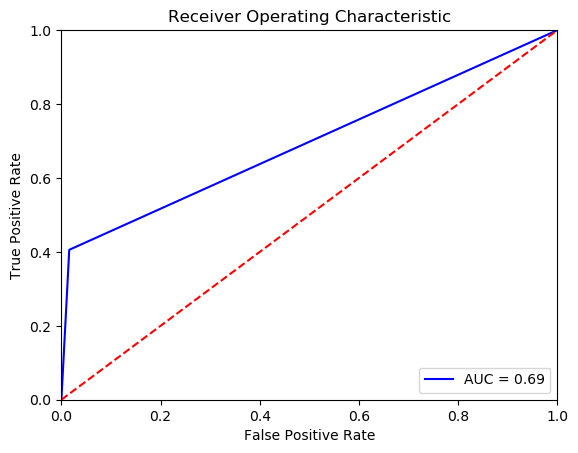

In [78]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.rcParams.update(plt.rcParamsDefault)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Results and Insights

As mentioned, my model (ExtraTreesClassfier) had an overall classification score of 0.996, with an AUC of 0.69.

To answer the question of what variables are most indicative of earning over 50k, feature_importances_ results were obtained from the machine-learning pipeline. As seen below, father's country of birth, the overarching industry, increased number of weeks worked per year, martital status, education, the occupation, etc., were some of the more important indicators of making over 50k per year. While year had the highest feature importance, exloratory analysis doesn't show stark differences of the 50k_threshold groups between 1994 and 1995.

Surprisingly, employment status, current enrolled in education institution, age, previous residency in the sunbelt, previous residency in another state, weight, and even sex and race were all found to have the lowest importance in differentiating those who make above 50k to those to make below 50k. If the category were further broken down, however, to top 1%, top 2-10%, middle class, working class, and below, some of these variables would likely have more weight.

In [127]:
%%time
variable_importance = final_est.steps[1][1].feature_importances_

CPU times: user 2.17 s, sys: 13.2 s, total: 15.4 s
Wall time: 1min 13s


In [134]:
sorted([(i, j) for i, j in zip(['age', 'class_of_worker', 'industry_code', 'occupation_code',
       'education', 'wage_per_hour', 'enrolled_in_edu_inst_last_wk',
       'marital_status', 'major_industry_code', 'major_occupation_code',
       'mace', 'hispanic_Origin', 'sex', 'member_of_a_labor_union',
       'reason_for_unemployment', 'full_or_part_time_employment_stat',
       'capital_gains', 'capital_losses', 'divdends_from_stocks',
       'tax_filer_status', 'region_of_previous_residence',
       'state_of_previous_residence', 'detailed_household_and_family_stat',
       'detailed_household_summary_in_household', 'instance_weight',
       'migration_code-change_in_msa', 'migration_code-change_in_reg',
       'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer',
       'family_members_under_18', 'country_of_birth_father',
       'country_of_birth_mother', 'country_of_birth_self', 'citizenship',
       'own_business_or_self_employed', 'veterans_benefits',
       'weeks_worked_in_year', 'year'], variable_importance)], key = lambda x: x[1], reverse = False)

[('full_or_part_time_employment_stat', 0.0027534301644716592),
 ('enrolled_in_edu_inst_last_wk', 0.002768263195847345),
 ('industry_code', 0.002919083437649699),
 ('age', 0.003538993807054597),
 ('migration_prev_res_in_sunbelt', 0.0045033717309283985),
 ('state_of_previous_residence', 0.004570064910435645),
 ('migration_code-change_in_msa', 0.004583394324352401),
 ('instance_weight', 0.004591063827943314),
 ('sex', 0.004607468077093011),
 ('mace', 0.00550816354914187),
 ('detailed_household_and_family_stat', 0.006715356320437181),
 ('reason_for_unemployment', 0.006953723959895588),
 ('member_of_a_labor_union', 0.008120169685081377),
 ('country_of_birth_mother', 0.008486790198316583),
 ('migration_code-change_in_reg', 0.009619422276790844),
 ('capital_losses', 0.010067683428580757),
 ('capital_gains', 0.010144572236503837),
 ('divdends_from_stocks', 0.010422600044572712),
 ('class_of_worker', 0.011168902613910202),
 ('citizenship', 0.01162073053398623),
 ('family_members_under_18', 0.01

In [690]:
# SGDclassification
SGDclassification_pipeline = Pipeline([
    ('union', FeatureUnion([ # Feature Union to process different variables
            ('numeric_transformed_features', Pipeline([
                ('selector', get_numeric_feat_data)
            ])),
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data)
            ]))#,
            # ('text_features', Pipeline([
            #    ('selector', get_text_data),
            #    ('CountVectorizer', CountVectorizer(max_features=65536, 
            #                                        binary=True, 
            #                                        ngram_range=(1,2))),
            #     ('TfidfTransformer', TfidfTransformer())
            #]))
         ])), # First used SDGRegressor for processing speed during the exploratory phase before using RandomForest
    #('SGDRegressor', linear_model.SGDRegressor(max_iter = 10000, tol = 1e-3, random_state = 42))
    #('Naive_Bayes', GaussianNB(priors=None, var_smoothing=1e-09))
    ('feature_selection', SelectFromModel(LinearSVC(max_iter = 4000,
                                                    penalty = "l1", 
                                                    dual = False,
                                                   random_state = 42))),
    #('ETRF_Classifier', ExtraTreesClassifier(max_features = 'sqrt',
    #                                                criterion = 'gini',
    #                                                tol = 1e-3,
    #                                                random_state = 42))
    ('SGDClassifier', linear_model.SGDClassifier(max_iter=10000,
                                                 loss = 'squared_hinge',
                                                 penalty = 'elasticnet',
                                                 tol = 1e-3,
                                                 class_weight = 'balanced',
                                                 random_state = 42))
    #('RF_Regressor', RandomForestRegressor(max_depth = 30, 
    #                                       max_features = 'sqrt', 
    #                                       criterion= 'mse', 
    #                                       random_state=42, 
    #                                       n_estimators=500))
])                                            

# Parameters for GridSearch
parameters = {
    'union__transformer_weights': [{'CountVectorizer__max_df': [0.75, 1.0]},
                                   {'CountVectorizer__max_features': [50000, 65536]},
                                   #{'CountVectorizer__ngram_range': [(1, 6),
                                   #                                 (1, 4),
                                   #                                 (1, 2),
                                   #                                 (2, 4),
                                   #                                 (2, 6),
                                   #                                 (4, 6)]},
                                   {'TfidfTransformer__use_idf': [True]},
                                   {'TfidfTransformer__norm': ['l1', 'l2']},
                                   {'TfidfTransformer__sublinear_tf': ['1 + log(tf)']}
                                  ],
    #'CountVectorizer__max_df': [0.75, 1.0],
    #'CountVectorizer__max_features': [50000, 65536],
    #'CountVectorizer__ngram_range': [(1, 2)],  # unigrams or bigrams
    #'CountVectorizer__binary': [True],
    #'TfidfTransformer__use_idf': [True],
    #'TfidfTransformer__norm': ['l1', 'l2'],
    #'TfidfTransformer__sublinear_tf': ['1 + log(tf)'],
    #'feature_selection__max_iter': [3500, 4500, 5500],
    'ETRF_Classifier__max_depth': [60, 80, 100],
    'ETRF_Classifier__n_estimators': [500, 600, 700, 800]
    #'Regressor__alpha': [0.001, 0.0001, 0.00001, 0.000001],
    #'Regressor__penalty': ['l2', 'elasticnet'],
}

In [694]:
%%time
X_train, X_test, y_train, y_test = give_data[0], give_data[1], give_data[2], give_data[3]

final_est = SGDclassification_pipeline.fit(X_train, y_train)
print(final_est.score(X_train, y_train))
y_pred = final_est.predict(X_test)
print(classification_report(y_test, y_pred))

0.6454293489973587
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     93576
           1       0.14      0.95      0.25      6186

   micro avg       0.65      0.65      0.65     99762
   macro avg       0.57      0.79      0.51     99762
weighted avg       0.94      0.65      0.74     99762

CPU times: user 4min 38s, sys: 1.29 s, total: 4min 40s
Wall time: 4min 58s


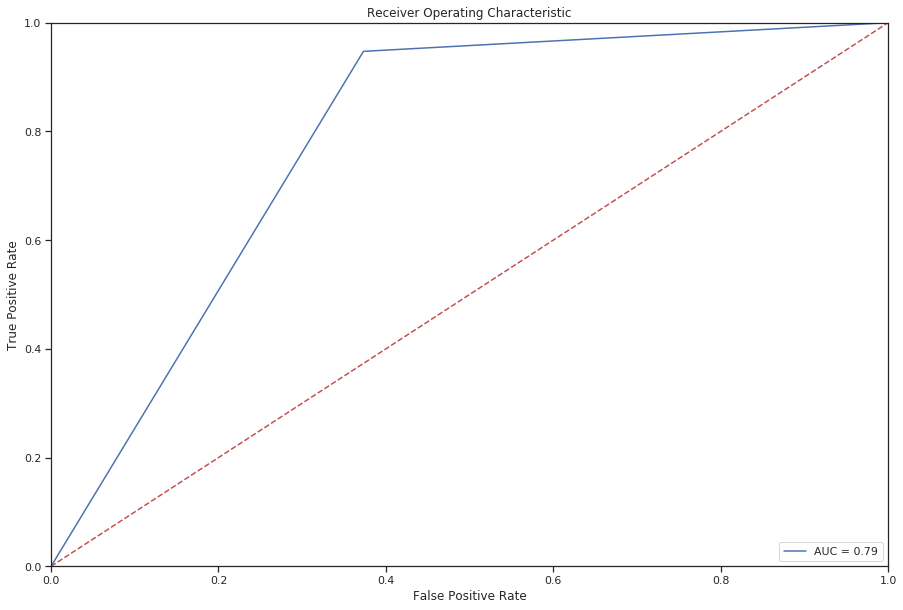

CPU times: user 530 ms, sys: 190 ms, total: 720 ms
Wall time: 491 ms


In [689]:
%%time

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()